  
# Trabajo Práctico 1

## Simulación de Eventos Discretos

#### Departamento de Computación - Facultad de Ciencias Exactas y Naturales - Universidad de Buenos Aires

11 de Octubre de 2021

**Grupo 04:** Confalonieri, Gisela - Lucero, Emiliano
    

----

# Modelo conceptual

En el presente trabajo modelaremos un **sistema de evaluación de un centro de atención telefónica de una entidad bancaria**. 

Una **simplificación** de este tipo de sistemas podría ser la siguiente:

* Una persona llama a la central telefónica de la entidad bancaria.
* Una contestadora automática solicita datos a la persona para derivarla al área correspondiente a su solicitud.
* El llamado es colocado en espera para ser atendido por un agente del área correspondiente.
* El agente atiende la llamada y resuelve la solicitud.
* Durante el recorrido de la llamada a través del sistema, se recopilan datos que serán utilizados en la generación de métricas de calidad de servicio.

El objetivo de nuestro modelo es **comparar posibles configuraciones en cuanto a la disposición de los agentes en cada una de las áreas de atención, para evaluar los cambios de performance (tiempo de demora en resolver una solicitud) según las métricas obtenidas**. Las posteriores simulaciones permitirían **analizar distintos escenarios en los que se observen mejoras en el servicio.**

## Estructura del modelo

Nuestro modelo comprenderá:

* Un **generador de las llamadas** que ingresan al centro de atención
* Una **mesa de entrada** que redirigirá las llamadas al área correspondiente
* Dos **áreas de atención específicas**, una para clientes y otra para no clientes
* Un **medidor de métricas de calidad**

Por lo tanto, un primer bosquejo de la estructura de nuestro modelo comprende los siguientes componentes:

### **Esquema conceptual general del modelo**

![esquema general](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-General.png)

A continuación presentaremos cada componente del sistema, con una descripción breve, un esquema conceptual, y su especificación formal DEVS.

### Generador de llamadas

* Representa las llamadas que recibe el centro de atención.
* Su único input corresponde a un evento que indica cuándo dejar de generar llamados.
* Periódicamente genera llamadas según alguna distribución.
* Cada llamada generada corresponde a un cliente o a una persona que aún no es cliente.

#### **Esquema conceptual del generador de llamadas**
  
![esquema generador](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-Generador.png)

#### **Especificación formal del generador de llamadas**

$ generadorDeLlamadas = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{parar\}$

$Y = \{llamada\}$

$S = \{generando,parado\}$

$\delta_{int}(generando) = generando$

$\delta_{ext}(generando,e,parar) = parado$

$\lambda(generando) =$ 
```c++
id <- número entero identificatorio //único para cada llamada generada en una simulación
es_cliente <- booleano aleatorio //true si es llamada de cliente, false para no cliente
enviar como output la tupla <id,es_cliente> //esta tupla representa la llamada
```

$ta(generando) = $ ```valor aleatorio según distirbuciónLlamada```

$ta(parado) = inf$

#### **Representación de estados y transiciones del generador de llamadas**
  
![estados_generador](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/generador_estados.png)

### Mesa de entrada

* Recibe las llamadas como input, y las redirige al área correspondiente.
  * Las llamadas ingresan a una cola de espera.
  * Un subcomponente va desencolando las llamadas y enviándolas al área correspondiente.

#### **Esquema conceptual de la mesa de entrada**
  
![esquema mesa](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-mesa_de_entrada.png)

#### **Especificación formal de la mesa de entrada y sus subcomponentes**

##### **Cola**

$Cola = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta>$

$X = \{entrada, liberar\}$

$Y = \{salida\}$

$S = \{estado \in \{encolando,vacia,liberando\},llamadasEncoladas,sigEstado,hayPedido\}$

$\delta_{int}((liberando,llE,0,hayP)) = (vacia,llE,0,hayP)$

$\delta_{int}((liberando,llE,1,hayP)) = (encolando,llE,1,hayP)$

$\delta_{ext}(s,e,x) =$

```c++
case port:
    entrada:
        s.llamadasEncoladas.push(x) //agrego la nueva llamada a la cola
        if s.hayPedido // si tengo un pedido esperando le doy esta llamada
            pasar a (liberando,s.llamadasEncoladas,s.sigEstado,false)
        else // si no me pidieron nada sigo encolando
            pasar a (encolando,s.llamadasEncoladas,s.sigEstado,s.hayPedido)
    liberar:
        if s.estado == encolando
            pasar a (liberando,s.llamadasEncoladas,s.sigEstado,s.hayPedido)
        if s.estado == vacia //no tengo llamadas asi que anoto para cuando entre una
            s.hayPedido <- true
```

$\lambda((liberando,llE,sigE,hayP)) =$

```c++
llam = llE.pop
if llE.empty
    sigE <- 0 // si es la ultima llamada encolada, luego me voy a vacia
else
    sigE <- 1 // si todavia hay mas llamadas, luego me voy a encolando
enviar llam por salida
```

$ta(encolando) = inf$

$ta(vacia) = inf$

$ta(liberando) = 0$

#### **Representación de estados y transiciones del generador de llamadas**
  
![estados_cola](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/Cola.png)

##### **Distribuidor de llamadas**

$ Distribuidor Llamadas = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante\}$

$Y = \{pedirLlamada, clientes, noClientes\}$

$S = \{pidiendo, esperando, enviando, llamada\}$

$\delta_{int}(pidiendo) = esperando$

$\delta_{int}(enviando) = pidiendo$

$\delta_{ext}(esperando, e, entrante) = enviando$

$\lambda(s) =$ 
```c++
case s:
    pidiendo:
        enviar 1 por pedirLlamada
    enviando:
        // Recibi una llamada de la cola
        if es llamada de cliente
            enviar llamada por clientes
        else
            enviar llamada por noClientes
    otherwise:
        error   
```

$ta(esperando) = inf$

$ta(pidiendo) = 0$

$ta(enviando) =$ ```valor de retardo aleatorio```

**Representación de estados y transiciones del generador de llamadas**
  
![estados_generador](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/mesadeentrada_estados.png)

##### **Mesa de entrada**

$ Mesa De Entrada = <X,Y, \{Cola, DistribuidorLlamadas\},EIC,EOC,IC,Select> $

$X = \{entrante\}$

$Y = \{llamadaCliente, llamadaNoCliente\}$

$EIC = \{(MesaDeEntrada.entrante, Cola.entrada)\}$

$EOC = \{ 
         (DistribuidorLlamadas.clientes, MesaDeEntrada.llamadaCliente),\\
         (DistribuidorLlamadas.noClientes, MesaDeEntrada.llamadaNoCliente)\}$

$IC = \{
        (Cola.salida, DistribuidorLlamadas.entrante),\\
        (DistribuidorLlamadas.pedirLLamada, Cola.liberar)\}$

$Select = \{ Cola, DistribuidorLlamadas \}$

 ### Áreas de atención específica

* Cada una de las áreas recibe como input las llamadas que llegan desde la mesa de entrada.
* Estas llamadas ingresan a una cola de espera.
* Un distrbuidor va desencolando las llamadas y asignándolas a los agentes que se encuentren disponibles.
* Cada agente atiende una llamada y resuelve la solicitud. 
* Cada área comunica, a través de sus outputs, el momento en que cada llamada es atendida por un agente y el momento en que cada agente resuelve la solicitud de una llamada y la misma finaliza.

#### **Esquema conceptual de las áreas de atención específica**
  
![esquema areas](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-areas_especificas.png)

#### **Especificación formal del área de atención y sus subcomponentes**

##### **Distribuidor agentes**

$ Distribuidor Agentes = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{pedido, entrante\}$

$Y = \{pedirLlamada, agente1, agente2\}$

$S = \{estado\in\{desocupado, pidiendo, esperando, enviando\},pedidosEnEspera,luegoDeEnviar, llamada\}$

$\delta_{int}((pidiendo,p,l))= (esperando,p,l)$

$\delta_{int}((enviando,p,0)) = (desocupado,p,0)$

$\delta_{int}((enviando,p,1)) = (pidiendo,p,1)$

$\delta_{ext}(s,e,x) =$

```c++
case s.estado:
    desocupado:
        if x == pedido
            s.pedidosEnEspera.push(x) //agrego el pedido a los pedidos en espera
            pasar a (pidiendo,s.pedidosEnEspera,s.luegoDeEnviar)
    esperando:
        if x == entrante
            pasar a (enviando,s.pedidosEnEspera,s.luegoDeEnviar)
```

$\lambda(s) =$ 

```c++
case s.estado:
    pidiendo:
        enviar 1 por pedirLlamada
    enviando:
        // Recibi una llamada de la cola
        desencolar s.pedidosEnEspera
        enviar s.llamada por puerto correspondiente al pedido desencolado
        if s.pedidosEnEspera.emtpy //si ya no hay pedidos encolados
            luegoDeEnviar = 0 // proximo estado desocupado
        else 
            luegoDeEnviar = 1 // proximo estado pidiendo
    otherwise:
        error
```

$ta(desocupado,p,l) = inf$

$ta(pidiendo,p,l) = 0$

$ta(esperando,p,l) = inf$

$ta(enviando,p,l) = 0$

**Representación de estados y transiciones del distribuidor a agentes**
  
![estados_distribuidoragentes](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/distribuidoragentes_estados.png)

##### **Agente**

$ Agente = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante\}$

$Y = \{pedido, finalizada\}$

$S = \{estado \in \{atendiendo, pidiendo\}, T, llamada,id\}$

$\delta_{int}((atendiendo,t,l,i)) = (pidiendo,t,l,i)$

$\delta_{ext}((pidiendo,t,l,id), e, x) =$ 

``` C++
T <- valor aleatorio dado por la distribución elegida
pasar a (atendiendo,T,x,id) //x es la llamada entrante
```

$\lambda((atendiendo,t,llam,id) =$ 

``` C++
// Estaba atendiendo y ya transcurrió ta, por lo que terminé de atender la llamada
// La libero y aviso que estoy libre, pidiendo que me pasen otra llamada
enviar llam por finalizada
enviar id por pedido
```

$ta((pidiendo,t,l,i)) = inf $

$ta((atendiendo,t,l,i)) = t$


**Representación de estados y transiciones del agente**

![estados_agente](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/agente_estados.png)

##### **Area de atención**

$ AreaAtencion = <X,Y, \{Cola, DistribuidorAgentes, Agente1, Agente2\},EIC,EOC,IC,Select> $

$X = \{entrante\}$

$Y = \{llamadaAtendida, llamadaFinalizada\}$

$EIC = \{(AreaAtencion.entrante, Cola.entrada)\}$

$EOC = \{ 
        (DistribuidorAgentes.agente1, AreaAtencion.llamadaAtendida),\\
        (DistribuidorAgentes.agente2, AreaAtencion.llamadaAtendida),\\
        (Agente1.finalizada, AreaAtencion.llamadaFinalizada),\\
        (Agente2.finalizada, AreaAtencion.llamadaFinalizada)
        \}$

$IC = \{
        (Cola.salida, DistribuidorAgentes.entrante),\\
        (DistribuidorAgentes.pedirLLamada, Cola.liberar),\\
        (DistribuidorAgentes.agente1, Agente1.entrante),\\
        (DistribuidorAgentes.agente2, Agente2.entrante),\\
        (Agente1.pedido, DistribuidorAgentes.pedido),\\
        (Agente2.pedido, DistribuidorAgentes.pedido)
        \}$

$Select = \{ Cola, DistribuidorAgentes, Agente1, Agente2 \}$

### Medidor de métricas

* Comprende diversos subcomponentes que evaluarán distintas métricas de calidad cada uno, a partir de los datos recibidos a lo largo del recorrido de la llamada por el centro de atención telefónica, a saber:
  * Momento en que arriba una llamada al servicio
  * Momento en que la llamada es atendida por un agente
  * Momento en que la solicitud es resuelta por un agente
* Nuestro primer bosquejo comprende las siguientes métricas:
  * Tiempo promedio que una llamada está aguardando ser atendida (es decir, desde que llega hasta que es atendida por un agente)
  * Tiempo máximo que una llamada estuvo aguardando ser atendida (es decir, desde que llega hasta que es atendida por un agente)
  * Tiempo promedio que una llamada consume dentro del centro de atención (es decir, desde que llega hasta que su solicitud se resuelve)
  * Tiempo máximo que una llamada consumió dentro del centro de atención (es decir, desde que llega hasta que su solicitud se resuelve)

#### **Esquema conceptual del medidor**
  
![esquema medidor](https://raw.githubusercontent.com/giselabelen/SED2021/master/imgs/SED2021-TP1-Medidor.png)

#### **Especificación formal del medidor**

$ Medidor = <X,Y,S,\delta_{int},\delta_{ext},\lambda,ta> $

$X = \{entrante, atendida, finalizada\}$

$Y = \{mediciones\}$

$S = \{midiendo, tiempoInicial, tiempoRestante, entrantesXTiempo, atendidasXTiempo, finalizadasXTiempo\}$

$\delta_{int}((m,tI,tR,eXT,aXT,fXT)) = (m,tI,tI,[],[],[])$ ```reseteo las variables cada vez que vence ta```

$\delta_{ext}(s, e, x) =$ 

``` C++
case port: //actualizo los diccionarios
    entrante:
        s.entrantesXTiempo[x.id] <- <timestamp, x.esCliente>
    atendida:
        s.atendidasXTiempo[x.id] <- <timestamp, x.esCliente>
    finalizada:
        s.finalizadasXTiempo[x.id] <- <timestamp, x.esCliente>
    otherwise:
        Error

s.tiempoRestante <- s.tiempoRestante - e //actualizo tiempo para seguir con lo que restaba de ta inicial
pasar a s
```

$\lambda(s) =$ 
```c++
//tiempo promedio y maximo en atender llamada
tAtender <- 0
maxAtender <- 0
para cada id en s.atendidasXTiempo
    t <- s.atendidasXTiempo[id][timestamp] - s.entrantesXTiempo[id][timestamp]
    tAtender += t
    if maxAtender < t
        maxAtender <- t
promAtender <- tAtender/s.atendidasXTiempo.length

//tiempo promedio y maximo en resolver llamada
tFin <- 0
maxFin <- 0
para cada id en s.finalizadasXTiempo
    t <- s.finalizadasXTiempo[id][timestamp] - s.entrantesXTiempo[id][timestamp]
    tFin += t
    if maxFin < t
        maxFin <- t
promFin <- tFin/s.finalizadasXTiempo.length

//armo la tupla para output
m = <promAtender,maxAtender,promFin,maxFin>
enviar m por mediciones
```

$ta(s) = s.tiempoRestante$

Luego de haber especificado detalladamente cada componente del sistema, presentamos a continuación la especificación DEVS del acoplado final.

#### **Especificación formal del centro de atención telefónica**

$ CentroAtencion$ = $<X,Y, \{GeneradorLlamadas, MesaDeEntrada, AreaClientes, AreaNoClientes, Medidor\},EIC,EOC,IC,Select>$

$X = \{parar\}$

$Y = \{metricas\}$

$EIC = \{ (CentroAtencion.parar, GeneradorLlamadas.parar) \}$

$EOC$ = $\{ (Medidor.medicion, CentroAtencion.metricas)\}$

$IC$ = $\{
        (GeneradorLLamadas.llamada, MesaDeEntrada.entrante),\\
        (GeneradorLLamadas.llamada, Medidor.entrante),\\
        (MesaDeEntrada.clientes, AreaClientes.entrante),\\
        (MesaDeEntrada.noClientes, AreaNoClientes.entrante),\\
        (AreaClientes.atendida, Medidor.atendida),\\
        (AreaClientes.finalizada, Medidor.finalizada),\\
        (AreaNoClientes.atendida, Medidor.atendida),\\
        (AreaNoClientes.finalizada, Medidor.finalizada),\\
        \}$

$Select = \{ GeneradorLlamadas, MesaDeEntrada, AreaClientes, AreaNoClientes, Medidor \}$

# Simulación

Preparamos el entorno

In [5]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

Copiamos los archivos del modelo a la carpeta examples de CD++

In [55]:
%%bash -s "$CDPP_EXAMPLES"

cp -r TP1-CentroAtencion $1/

Compilamos el simulador

In [56]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src

# make clean

# Correr para compilar viendo cada paso
make -j4


g++ -c -I../../../src/cd++/warped -I../../../src/cd++/warped/notime -I../../../src/cd++/warped/notime/obj -I../../../src/cd++/warped/common -I../../../src/cd++/warped/common/obj -I../../../src/cd++/val -I../../../src/cd++/val/obj -I../../../src/cd++/atomics -I../../../src/cd++/atomics/generator -I../../../src/cd++/atomics/generator/obj -I../../../src/cd++/atomics/generator/.ipynb_checkpoints -I../../../src/cd++/atomics/qss -I../../../src/cd++/atomics/qss/obj -I../../../src/cd++/atomics/transducer -I../../../src/cd++/atomics/transducer/obj -I../../../src/cd++/atomics/cpu -I../../../src/cd++/atomics/cpu/obj -I../../../src/cd++/atomics/queue -I../../../src/cd++/atomics/queue/obj -I../../../src/cd++/atomics/queue/.ipynb_checkpoints -I../../../src/cd++/model -I../../../src/cd++/model/obj -I../../../src/cd++/model/state -I../../../src/cd++/model/state/obj -I../../../src/cd++/proc -I../../../src/cd++/proc/obj -I../../../src/cd++/proc/state -I../../../src/cd++/proc/state/obj -I../../../src/cd+

In file included from register.cpp:6:0:
Agente.h:9:0: warning: "ATOMIC_MODEL_NAME" redefined
 #define ATOMIC_MODEL_NAME "Agente" // cambiar nombre
 ^
In file included from register.cpp:4:0:
GeneradorLlamadas.h:9:0: note: this is the location of the previous definition
 #define ATOMIC_MODEL_NAME "GeneradorLlamadas" // cambiar nombre
 ^
In file included from register.cpp:7:0:
DistribuidorLlamadas.h:9:0: warning: "ATOMIC_MODEL_NAME" redefined
 #define ATOMIC_MODEL_NAME "DistribuidorLlamadas" // cambiar nombre
 ^
In file included from register.cpp:6:0:
Agente.h:9:0: note: this is the location of the previous definition
 #define ATOMIC_MODEL_NAME "Agente" // cambiar nombre
 ^
In file included from register.cpp:8:0:
DistribuidorAgentes.h:9:0: warning: "ATOMIC_MODEL_NAME" redefined
 #define ATOMIC_MODEL_NAME "DistribuidorAgentes" // cambiar nombre
 ^
In file included from register.cpp:7:0:
DistribuidorLlamadas.h:9:0: note: this is the location of the previous definition
 #define ATOMIC_MODEL_

CalledProcessError: Command 'b'\ncd $1/TP1-CentroAtencion/src\n\n# make clean\n\n# Correr para compilar viendo cada paso\nmake -j4\n'' returned non-zero exit status 2.

## Tests

A continuación probaremos los distintos componentes para corroborar su funcionamiento, previo a la experimentación con el modelo completo.

### GeneradorLlamadas

Primero probamos generar las llamadas con distribución constante en el tiempo.

In [9]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_generador1.ma  \
         -e ../model/test_generador1.ev  \
         -l ../test_generador1.log \
         -o ../test_generador1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_generador1.ma
Loading events from ../model/test_generador1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_generador1.log
Output to: ../test_generador1.out
Tolerance set to: 1e-

Como se muestra en la tabla resultante a continuación, el generador ha generado llamadas a intervalos constantes de tiempo (1 segundo).

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# definimos los path a los archivos de interés
OUT_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_generador1.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value: str):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

# veamos cómo luce el dataframe con los datos de salida
salida

,time,port,value
0,0.0,out,"(0.0, 1.0)"
1,1.0,out,"(1.0, 1.0)"
2,2.0,out,"(2.0, 0.0)"
3,3.0,out,"(3.0, 1.0)"
4,4.0,out,"(4.0, 1.0)"
...,...,...,...
56,56.0,out,"(56.0, 0.0)"
57,57.0,out,"(57.0, 1.0)"
58,58.0,out,"(58.0, 0.0)"
59,59.0,out,"(59.0, 0.0)"


Luego probamos generar llamadas con distribución de poisson con media=5.

In [21]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_generador2.ma  \
         -e ../model/test_generador2.ev  \
         -l ../test_generador2.log \
         -o ../test_generador2.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_generador2.ma
Loading events from ../model/test_generador2.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_generador2.log
Output to: ../test_generador2.out
Tolerance set to: 1e-

En el gráfico siguiente, se pretende mostrar que las llamadas se generan efectivamente con la distribución deseada.

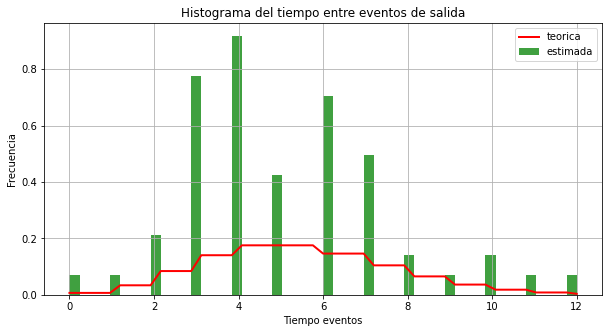

In [28]:
import scipy.stats as sps

# definimos los path a los archivos de interés
OUT_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_generador2.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value: str):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

# tiempo entre eventos de salida
x_values = np.diff(salida[TIME_COL])
plt.figure(figsize=(10,5))

# histograma de los eventos de salida
n, bins, patches = plt.hist(x_values, 50, density=True, facecolor='g', alpha=0.75,label='estimada')

# probability mass function
_mu=5
e = sps.poisson.pmf(bins.astype(int), _mu,loc=0)
plt.plot(bins,e,'r',linewidth=2,label='teorica')

plt.xlabel('Tiempo eventos')
plt.ylabel('Frecuencia')
plt.title('Histograma del tiempo entre eventos de salida')
plt.grid(True)
plt.legend();

### Agente

Para testear este componente, lo conectamos a una instancia de generador de llamadas, de manera que el puerto de salida del generador envíe llamadas al puerto de entrada del agente. El generador se configuró con distribución constante, y el tiempo de demora en resolver cada llamada atendida por el agente se estableció siguiendo una distribución exponencial con media 5.

El objetivo de esta prueba es verificar que cada llamada recibida por el agente es atendida y finalizada siguiendo los tiempos establecidos, y que luego de finalizar una llamada el agente solicita otra.

In [30]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_agente1.ma  \
         -e ../model/test_agente1.ev  \
         -l ../test_agente1.log \
         -o ../test_agente1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_agente1.ma
Loading events from ../model/test_agente1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_agente1.log
Output to: ../test_agente1.out
Tolerance set to: 1e-08
Configura

En la siguiente tabla podemos identificar los siguientes aspectos:

* Cuando el agente solicita una llamada (valor 1 por puerto ```pedido``` del modelo *agente1*), toma la última llamada generada (puerto ```llamada``` del modelo *generador*) y la finaliza un tiempo después (puerto ```finalizada``` del modelo *agente1*). Esto se observa en los valores que identifican a la llamada y en el valor de tiempo señalado en cada caso.
* Cuando se genera una llamada mientras el agente se encuentra "atendiendo" (es decir, ha tomado una llamada anterior y aún no la ha finalizado) dicha llamada es descartada. Esto se observa en la falta de un mensaje por puerto ```finalizada``` del modelo *agente1* para dicho valor de llamada.
* Cuando el agente finaliza una llamada, inmediatamente solicita la siguiente.  Esto se observa en la marca de tiempo para dichos mensajes.

In [45]:
import os

LOG_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_agente1.log"

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    # VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )
# veamos cómo luce el dataframe con los datos de salida
#parsed_logs

df_top = parsed_logs["top"]
df_top.loc[df_top[MESSAGE_TYPE_COL] == "Y"]

,0,1,message_type,time,model_origin,port,value,model_dest
4,0,L,Y,0.000000,generador(01),llamada,"[0, 0]",top(03)
6,0,L,Y,0.000000,agente1(02),pedido,1.00000,top(03)
12,0,L,Y,1.118681,agente1(02),finalizada,"[0, 0]",top(03)
13,0,L,Y,1.118681,agente1(02),pedido,1.00000,top(03)
18,0,L,Y,5.000000,generador(01),llamada,"[1, 1]",top(03)
24,0,L,Y,7.351855,agente1(02),finalizada,"[1, 1]",top(03)
25,0,L,Y,7.351855,agente1(02),pedido,1.00000,top(03)
30,0,L,Y,10.000000,generador(01),llamada,"[2, 1]",top(03)
36,0,L,Y,10.404184,agente1(02),finalizada,"[2, 1]",top(03)
37,0,L,Y,10.404184,agente1(02),pedido,1.00000,top(03)


### Cola

En el caso de este componente, hemos adaptado el modelo ```queue``` que ya viene implementado con el simulador a nuestra especificación. 

Esta nueva versión sólo cambia los nombres de los puertos y añade las variables de estado que permiten manejar el comportamiento cuando la cola está vacía (tanto cuando llega un pedido para desencolar como cuando se desencola el último elemento).

Las siguientes pruebas conectan una instancia de cola con un generador de llamadas y un agente, de manera de verificar que las llamadas generadas ingresan a la cola, y son desencoladas en la medida que el agente las solicita. El primer test establece una distribución constante para el generador de llamadas, y el segundo una distribución Poisson.

In [57]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_cola1.ma  \
         -e ../model/test_cola1.ev  \
         -l ../test_cola1.log \
         -o ../test_cola1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_cola1.ma
Loading events from ../model/test_cola1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_cola1.log
Output to: ../test_cola1.out
Tolerance set to: 1e-08
Configuration to 

In [58]:
import os

LOG_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_cola1.log"

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    # VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )
# veamos cómo luce el dataframe con los datos de salida
#parsed_logs

df_top = parsed_logs["top"]
df_top.loc[df_top[MESSAGE_TYPE_COL] == "Y"]

,0,1,message_type,time,model_origin,port,value,model_dest
5,0,L,Y,0.000000,generador(01),llamada,"[0, 1]",top(04)
7,0,L,Y,0.000000,agente1(03),pedido,1.00000,top(04)
14,0,L,Y,1.000000,cola(02),salida,"[0, 1]",top(04)
20,0,L,Y,1.523283,agente1(03),finalizada,"[0, 1]",top(04)
21,0,L,Y,1.523283,agente1(03),pedido,1.00000,top(04)
27,0,L,Y,5.000000,generador(01),llamada,"[1, 1]",top(04)
33,0,L,Y,6.000000,cola(02),salida,"[1, 1]",top(04)
39,0,L,Y,10.000000,generador(01),llamada,"[2, 0]",top(04)
45,0,L,Y,12.591715,agente1(03),finalizada,"[1, 1]",top(04)
46,0,L,Y,12.591715,agente1(03),pedido,1.00000,top(04)


En este primer test, notamos un comportamiento no esperado: en cierto momento empiezan a encolarse llamadas y no se derivan al agente. <font color='red'>Queda pendiente verificar por qué sucede esto. Notar que esto impactará en los posteriores tests donde se utilice una instancia de cola.</font>

In [59]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_cola2.ma  \
         -e ../model/test_cola2.ev  \
         -l ../test_cola2.log \
         -o ../test_cola2.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_cola2.ma
Loading events from ../model/test_cola2.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_cola2.log
Output to: ../test_cola2.out
Tolerance set to: 1e-08
Configuration to 

In [60]:
import os

LOG_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_cola2.log"

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    # VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )
# veamos cómo luce el dataframe con los datos de salida
#parsed_logs

df_top = parsed_logs["top"]
df_top.loc[df_top[MESSAGE_TYPE_COL] == "Y"]

,0,1,message_type,time,model_origin,port,value,model_dest
5,0,L,Y,0.000000,generador(01),llamada,"[0, 0]",top(04)
7,0,L,Y,0.000000,agente1(03),pedido,1.00000,top(04)
14,0,L,Y,1.000000,cola(02),salida,"[0, 0]",top(04)
20,0,L,Y,2.429790,agente1(03),finalizada,"[0, 0]",top(04)
21,0,L,Y,2.429790,agente1(03),pedido,1.00000,top(04)
27,0,L,Y,6.000000,generador(01),llamada,"[1, 0]",top(04)
33,0,L,Y,7.000000,cola(02),salida,"[1, 0]",top(04)
39,0,L,Y,11.000000,generador(01),llamada,"[2, 0]",top(04)
45,0,L,Y,21.000000,generador(01),llamada,"[3, 1]",top(04)
51,0,L,Y,25.000000,generador(01),llamada,"[4, 0]",top(04)


### DistribuidorLlamadas

Para testear este componente, hemos conectado una instancia de generador de llamadas con una cola, y la salida de esa instancia de cola con la entrada del distribuidor. El objetivo es verificar el comportamiento del distribuidor en cuanto al envío de la llamada por el puerto de salida correspondiente (según se trate de una llamada de un cliente o no).

In [63]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_distribuidorllamadas1.ma  \
         -e ../model/test_distribuidorllamadas1.ev  \
         -l ../test_distribuidorllamadas1.log \
         -o ../test_distribuidorllamadas1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_distribuidorllamadas1.ma
Loading events from ../model/test_distribuidorllamadas1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_distribuidorllamadas1.log
Output to: ../test_dis

En la siguiente tabla podemos identificar los siguientes aspectos:

* Cuando el distribuidor solicita una llamada a la cola (valor 1 por puerto ```pedirllamada``` del modelo *distribuidor*), toma la llamada que envía la cola (puerto ```salida``` del modelo *cola*) y la envía por un puerto de salida un tiempo después (siguiendo una distribución especificada). Esto se observa en la marca de tiempo para dichos mensajes.
* Las llamadas que toma el distribuidor son enviadas por el puerto de salida correspondiente. Esto se observa en los valores de llamada, ya que los que tienen segunda componente 0 se envían por el puerto ```nocliente```, y los que tienen segunda componente 1 se envían por el puerto ```cliente```.

In [64]:
import os

LOG_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_distribuidorllamadas1.log"

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    # VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )
# veamos cómo luce el dataframe con los datos de salida
#parsed_logs

df_top = parsed_logs["top"]
df_top.loc[df_top[MESSAGE_TYPE_COL] == "Y"]

,0,1,message_type,time,model_origin,port,value,model_dest
5,0,L,Y,0.000000,generador(01),llamada,"[0, 0]",top(04)
7,0,L,Y,0.000000,distribuidor(03),pedirllamada,1.00000,top(04)
14,0,L,Y,1.000000,cola(02),salida,"[0, 0]",top(04)
20,0,L,Y,1.592263,distribuidor(03),noclientes,"[0, 0]",top(04)
25,0,L,Y,1.592263,distribuidor(03),pedirllamada,1.00000,top(04)
31,0,L,Y,5.000000,generador(01),llamada,"[1, 1]",top(04)
37,0,L,Y,6.000000,cola(02),salida,"[1, 1]",top(04)
43,0,L,Y,6.076942,distribuidor(03),clientes,"[1, 1]",top(04)
48,0,L,Y,6.076942,distribuidor(03),pedirllamada,1.00000,top(04)
54,0,L,Y,10.000000,generador(01),llamada,"[2, 0]",top(04)


### DistribuidorAgentes

Para testear este componente, hemos conectado una instancia de generador de llamadas con una cola, y la salida de esa instancia de cola con la entrada del distribuidor. A su vez, se ha conectado el distribuidor a dos instancias de agente.

El objetivo es verificar el comportamiento del distribuidor en cuanto al envío de las llamadas por el puerto correspondiente al agente que lo haya solicitado.

In [66]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_distribuidoragentes1.ma  \
         -e ../model/test_distribuidoragentes1.ev  \
         -l ../test_distribuidoragentes1.log \
         -o ../test_distribuidoragentes1.out

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/test_distribuidoragentes1.ma
Loading events from ../model/test_distribuidoragentes1.ev
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../test_distribuidoragentes1.log
Output to: ../test_distri

En la siguiente tabla podemos identificar los siguientes aspectos:

* Cuando el distribuidor solicita una llamada a la cola (valor 1 por puerto ```pedirllamada``` del modelo *distribuidor*), toma la llamada que envía la cola (puerto ```salida``` del modelo *cola*) y la envía por un puerto de salida un tiempo después (siguiendo una distribución especificada). 
* El distribuidor solicita una llamada a la cola cuando un agente lo requiere.
* El distribuidor envía la llamada recibida por parte de la cola a cada agente que lo solicita.

Todos estos puntos se observan en la marca de tiempo de cada mensaje y el valor de las llamadas.

In [67]:
import os

LOG_FILENAME = str(CDPP_EXAMPLES)+"/TP1-CentroAtencion/test_distribuidoragentes1.log"

log_file_per_component = {}
parsed_logs = {}

with open(LOG_FILENAME, 'r') as main_log_file:
    main_log_file.readline()  # Ignore first line
    log_dir = os.path.dirname(LOG_FILENAME)
    for line in main_log_file:
        name, path = line.strip().split(' : ')
        log_file_per_component[name] = (path if os.path.isabs(path) else
                                        log_dir + '/' + path.split('/')[-1])

df_converters = {
    # VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}
    
for logname, filename in log_file_per_component.items():
    parsed_logs[logname] = pd.read_csv(filename,
                                       delimiter=r' /\s+',
                                       engine='python',  # C engine doesnt work for regex
                                       converters=df_converters,
                                       names=[0, 1,  # Not sure what first two cols are
                                              MESSAGE_TYPE_COL,
                                              TIME_COL,
                                              MODEL_ORIGIN_COL,
                                              PORT_COL,
                                              VALUE_COL,
                                              MODEL_DEST_COL]
                                      )
# veamos cómo luce el dataframe con los datos de salida
#parsed_logs

df_top = parsed_logs["top"]
df_top.loc[df_top[MESSAGE_TYPE_COL] == "Y"]

,0,1,message_type,time,model_origin,port,value,model_dest
7,0,L,Y,0.000000,generador(01),llamada,"[0, 0]",top(06)
9,0,L,Y,0.000000,agente1(04),pedido,1.00000,top(06)
11,0,L,Y,0.000000,agente2(05),pedido,2.00000,top(06)
20,0,L,Y,0.000000,distribuidor(03),pedirllamada,1.00000,top(06)
26,0,L,Y,1.000000,cola(02),salida,"[0, 0]",top(06)
...,...,...,...,...,...,...,...,...
293,0,L,Y,49.061871,agente1(04),pedido,1.00000,top(06)
299,0,L,Y,49.061871,distribuidor(03),pedirllamada,2.00000,top(06)
305,0,L,Y,50.000000,generador(01),llamada,"[10, 1]",top(06)
311,0,L,Y,55.000000,generador(01),llamada,"[11, 1]",top(06)


In [68]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/

cat test_distribuidoragentes1.log06 | grep Y

0 / L / Y / 00:00:00:000:0 / generador(01) / llamada / [0, 0] / top(06)
0 / L / Y / 00:00:00:000:0 / agente1(04) / pedido /      1.00000 / top(06)
0 / L / Y / 00:00:00:000:0 / agente2(05) / pedido /      2.00000 / top(06)
0 / L / Y / 00:00:00:000:0 / distribuidor(03) / pedirllamada /      1.00000 / top(06)
0 / L / Y / 00:00:01:000:0 / cola(02) / salida / [0, 0] / top(06)
0 / L / Y / 00:00:01:000:0 / distribuidor(03) / agente1 / [0, 0] / top(06)
0 / L / Y / 00:00:05:000:0 / generador(01) / llamada / [1, 1] / top(06)
0 / L / Y / 00:00:07:107:0.161522 / agente1(04) / finalizada / [0, 0] / top(06)
0 / L / Y / 00:00:07:107:0.161522 / agente1(04) / pedido /      1.00000 / top(06)
0 / L / Y / 00:00:07:107:0.161522 / distribuidor(03) / pedirllamada /      2.00000 / top(06)
0 / L / Y / 00:00:08:107:0.161522 / cola(02) / salida / [1, 1] / top(06)
0 / L / Y / 00:00:08:107:0.161522 / distribuidor(03) / agente2 / [1, 1] / top(06)
0 / L / Y / 00:00:08:557:0.0526719 / agente2(05) / finalizada / [1, 1

### Medidor

Para testear este componente, hemos conectado una instancia de generador de llamadas a cada uno de los puertos de entrada del medidor, todos con distribución de generación constante pero distinto valor de retardo. De esta manera, buscamos simular el comportamiento de las llamadas dentro del sistema completo, llegando primero una llamada como entrante, posteriormente como atendida y finalmente como finalizada.

El objetivo es verficar que las métricas que el medidor envía como salida sean correctas para los datos de entrada.

In [ ]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/test_medidor1.ma  \
         -e ../model/test_medidor1.ev  \
         -l ../test_medidor1.log \
         -o ../test_medidor1.out

En esta prueba estamos obteniendo errores de tiempo negativo. <font color='red'>Queda pendiente verificar por qué sucede esto. Notar que esto impactará en los posteriores tests donde se utilice una instancia de medidor.</font>

## Experimentación con el modelo completo

Habiendo testeado cada componente atómico por separado, procederemos a mostrar la simulación del modelo completo del centro de atención telefónica, tal como fue especificado.

In [ ]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/TP1-CentroAtencion/src/

bin/cd++ -m ../model/centro_atencion.ma  \
         -e ../model/centro_atencion.ev  \
         -l ../centro_atencion.log \
         -o ../centro_atencion.out

Dado que el componente medidor no funciona correctamente, no hemos podido verificar el comportamiento del sistema completo. <font color='red'>Queda pendiente.</font>